In [1]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [2]:

%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
states_stats_df = s.load_object('states_stats_df')
color_dict = s.load_object('states_abbreviation_color_dict')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

%pprint
dir()

D:\Documents\Repositories\notebooks\covid19\ipynb\US County Population Density.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
Pretty printing has been turned OFF


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'color_dict', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_ending_with', 'prin


----


Like I say, I'm imagining that a state has $M$ different regions with populations $n_1$, $n_2$, $\ldots$, $n_M$, and areas $A_1$, $A_2$, $\ldots$, $A_M$.


So then, the total population $n = \sum_{i=1}^M n_i$.


The weighted measure I'm suggesting is $\left( \sum_{i=1}^M n_i^2/A_i \right)/n$.

In [14]:

facebook_aspect_ratio = 1.91
twitter_aspect_ratio = 16/9
color_dict = s.load_object('states_abbreviation_color_dict')
def plot_lived_density(qe_column='Population_Density', qr_column='Later_Count',
                       xlabel='Lived population density', ylabel='No. of deaths 10 days after hitting 5 deaths', aspect_ratio=1.91):
    columns_list = [qe_column, qr_column]
    df = density_df[columns_list].dropna(axis='index', how='any')
    x = df[qe_column]
    y = df[qr_column]
    facet_grid = sns.lmplot(x=qe_column, y=qr_column, data=df, scatter=True, scatter_kws={'s': 1.0, 'color': 'grey'})
    set_list = facet_grid.set(xlabel=xlabel, ylabel=ylabel,
                              title='Rate of spread vs Lived population density')
    fig_width = 18
    fig_height = fig_width/aspect_ratio
    set_list = facet_grid.fig.set(figheight=fig_height, figwidth=fig_width)
    
    # Get r squared value
    pearsonr_tuple = pearsonr(df[qe_column], df[qr_column])
    pearson_r = pearsonr_tuple[0]
    pearsonr_statement = str('%.2f' % pearson_r)
    coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
    p_value = pearsonr_tuple[1]
    if p_value < 0.0001:
        pvalue_statement = '<0.0001'
    else:
        pvalue_statement = '=' + str('%.4f' % p_value)
    s_str = r'$r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$'
    set_list = facet_grid.fig.text(0.75, 0.9, s_str, alpha=0.5, fontsize='x-large')

    label_point(df[qe_column], df[qr_column], df.index.to_series(), plt.gca())
    
    ax = facet_grid.ax
    ax.set_alpha = 0.1
    left, right = ax.get_xlim()
    left -= 0.125
    right += 0.125
    xlim_tuple = (left, right)
    xlim_tuple = ax.set_xlim(xlim_tuple)

In [15]:

from scipy.stats import pearsonr
import seaborn as sns

density_df = s.load_object('density_df')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        state_abbreviation = point.val
        x = point.x
        y = point.y
        kwargs = dict(textcoords='offset points', ha='left', va='bottom', fontsize='small',
                      bbox=dict(boxstyle='round,pad=0.5', fc=color_dict[state_abbreviation], alpha=0.5),
                      arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        if state_abbreviation == 'NC':
            annotation = plt.annotate('{}'.format(state_abbreviation), xy=(x, y), xytext=(25, 40), **kwargs)
        elif state_abbreviation == 'OH':
            annotation = plt.annotate('{}'.format(state_abbreviation), xy=(x, y), xytext=(25, 40), **kwargs)
        elif state_abbreviation == 'GA':
            annotation = plt.annotate('{}'.format(state_abbreviation), xy=(x, y), xytext=(-25, 50), **kwargs)
        elif state_abbreviation == 'IN':
            annotation = plt.annotate('{}'.format(state_abbreviation), xy=(x, y), xytext=(-25, 50), **kwargs)
        else:
            annotation = plt.annotate('{}'.format(state_abbreviation), xy=(x, y), xytext=(-5, -8), **kwargs)
        #ax.text(point['x']+.02, point['y'], state_abbreviation)

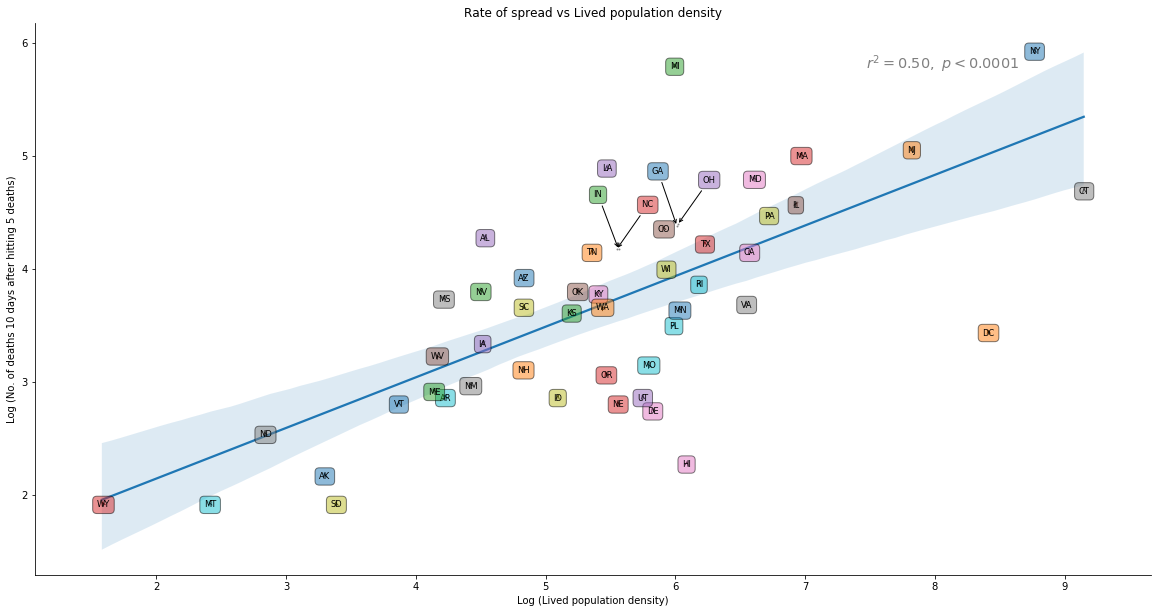

In [16]:

plot_lived_density(qe_column='Log_Weighted_Density', qr_column='Log_Later_Count',
                   xlabel='Log (Lived population density)', ylabel='Log (No. of deaths 10 days after hitting 5 deaths)',
                   aspect_ratio=18/9)


----

In [12]:

import numpy as np

density_df = s.load_object('density_df')
density_df['Log_Weighted_Density'] = density_df.Weighted_Density.map(lambda x: np.log(x))
density_df['Log_Later_Count'] = density_df.Later_Count.map(lambda x: np.log(x))
s.store_objects(density_df=density_df)
s.save_dataframes(include_index=True, density_df=density_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\density_df.pickle
Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\density_df.csv


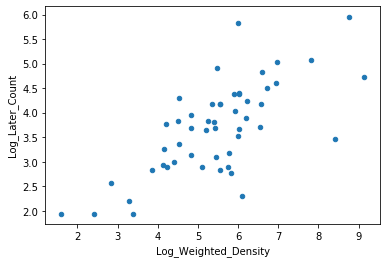

In [13]:

density_df = s.load_object('density_df')
AxesSubplot_obj = density_df.plot.scatter(x='Log_Weighted_Density', y='Log_Later_Count')

In [5]:

counties_df = s.load_object('counties_df')
weighted_density_dict = s.load_object('weighted_density_dict')
f_str = 'The top five US states by standard deviation of county population are {}.'
top5_list = counties_df.groupby('State_Name').std().sort_values('Estimate_2019', ascending=False).index.tolist()[:5]
f_str.format(conjunctify_list(['{} ({} weighted density)'.format(sn, round(weighted_density_dict[sn], 1)) for sn in top5_list]))

No pickle exists at D:\Documents\Repositories\notebooks\covid19\saves\pickle\weighted_density_dict.pickle - attempting to load as csv.
No csv exists at D:\Documents\Repositories\notebooks\covid19\saves\csv\weighted_density_dict.csv - attempting to download from URL.


ValueError: Invalid file path or buffer object type: <class 'NoneType'>

[]


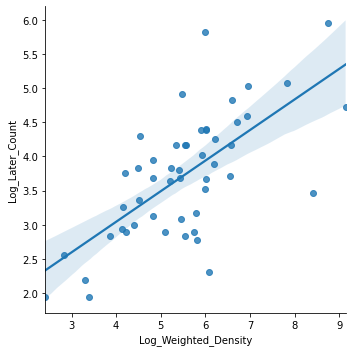

In [58]:

qe_column='Log_Weighted_Density'
qr_column='Log_Later_Count'
xlabel='Lived population density'
ylabel='No. of deaths 10 days after hitting 5 deaths'
aspect_ratio=1.91
columns_list = [qe_column, qr_column]
df = density_df[columns_list].dropna(axis='index', how='any')
x = df[qe_column]
y = df[qr_column]
facet_grid = sns.lmplot(x=qe_column, y=qr_column, data=df, scatter=True)
print(['facet_grid.ax.{}'.format(fn) for fn in dir(facet_grid.ax) if 'marker' in fn.lower()])

In [38]:

ax = facet_grid.ax
print(['ax.{}'.format(fn) for fn in dir(ax) if 'alpha' in fn.lower()])
ax.set_alpha?

['ax._alpha', 'ax.get_alpha', 'ax.set_alpha']


Signature: ax.set_alpha(alpha)
Docstring:
Set the alpha value used for blending - not supported on all backends.

Parameters
----------
alpha : float or None
File:      c:\users\577342\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\artist.py
Type:      method



----

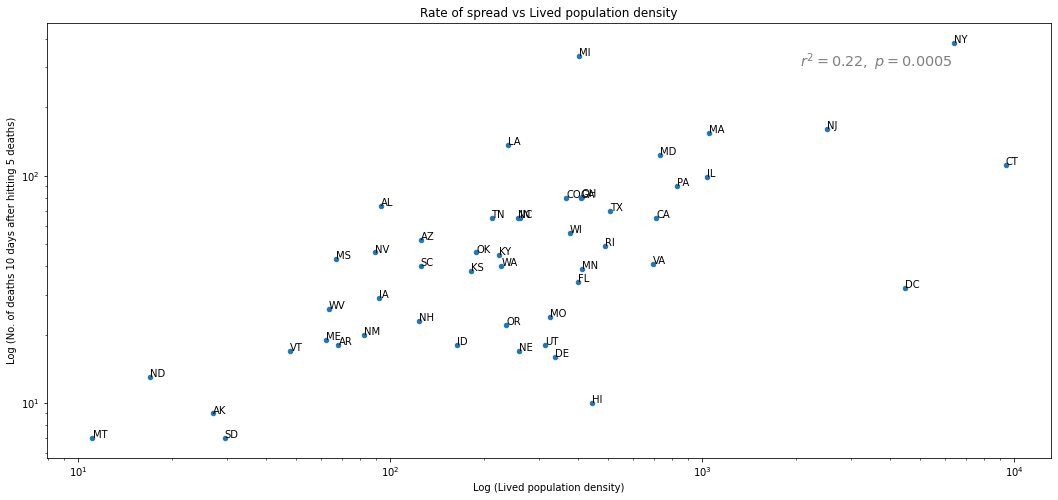

In [16]:

from scipy import stats
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, autoscale_on=True)
ax.set_xscale('log')
ax.set_yscale('log')
columns_list = ['Weighted_Density', 'Later_Count']
df = density_df[columns_list].dropna(axis='index', how='any')
x = df['Weighted_Density']
y = df['Later_Count']

'''
# Compute the slope, intercept and 90% confidence interval.
# For comparison, also compute the least-squares fit with linregress:
res = stats.theilslopes(np.log(y), np.log(x), 0.90)
lsq_res = stats.linregress(np.log(x), np.log(y))

# Plot the results
ax.plot(x, lsq_res[1] + lsq_res[0] * x, 'g-')
ax.plot(x, res[1] + res[0] * x, 'r-')
ax.plot(x, res[1] + res[2] * x, 'r--')
ax.plot(x, res[1] + res[3] * x, 'r--')'''

# Get r squared value
pearsonr_tuple = pearsonr(x, y)
pearson_r = pearsonr_tuple[0]
pearsonr_statement = str('%.2f' % pearson_r)
coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
p_value = pearsonr_tuple[1]
if p_value < 0.0001:
    pvalue_statement = '<0.0001'
else:
    pvalue_statement = '=' + str('%.4f' % p_value)
s_str = r'$r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$'

text_tuple = ax.text(0.75, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
ax.set_title('Rate of spread vs Lived population density')
AxesSubplot_obj = density_df.plot.scatter(x='Weighted_Density', y='Later_Count', ax=ax)
ax.set_xlabel('Log (Lived population density)')
ax.set_ylabel('Log (No. of deaths 10 days after hitting 5 deaths)')
label_point(x, y, df.index.to_series(), plt.gca()) 


----

In [15]:

density_df.Standard_Population_Density.std()

Standard_Population_Density    892.467479
Standard_Population_Density    892.467479
dtype: float64


----
# Clean the Data


## Moved scraped values into columns

In [285]:

scraped_counties_df = s.load_object('scraped_counties_df')
scraped_counties_df.sample(5)

,state_name,county_name,column_name,column_value
66979,Washington,Pierce County,Seat,Tacoma
5278,California,Shasta County,Region,Sacramento Valley/Cascade Range
12605,Idaho,Butte County,Area Total,"2,234 sq mi (5,790 km2)"
22624,Kentucky,Adair County,Time zone Summer (DST),UTC−5 (CDT)
26196,Louisiana,Rapides Parish,Area Total,"1,362 sq mi (3,530 km2)"


In [390]:

idx_dict = {}
idx_list = []
for idx_key in scraped_counties_df.column_name.value_counts().index:
    idx_key = re.sub(' \(population\)', '', idx_key)
    if 'population' in idx_key.lower():
        idx_list.append(idx_key)
for idx_key in idx_list:
    idx_dict[idx_key] = None
s.store_objects(idx_dict=idx_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\idx_dict.pickle


In [391]:

idx_dict = s.load_object('idx_dict')
acronym_regex = re.compile('[A-Z]{2,}')
for idx_key in scraped_counties_df.column_name.value_counts().index:
    if 'population' not in idx_key.lower():
        idx_value = re.sub('\[\d+\]', '', idx_key)
        idx_value = re.sub('\(s\)', 's', idx_value)
        tuple_list = []
        for match_obj in acronym_regex.finditer(idx_value):
            acronym_str = match_obj.group()
            acronym_transform = '_'.join(list(acronym_str))
            idx_value = re.sub(acronym_str, acronym_transform, idx_value)
            transform_tuple = (acronym_str, acronym_transform)
            tuple_list.append(transform_tuple)
        idx_value = '_'.join(re.sub('[^A-Za-z0-9]+', ' ', idx_value).strip().lower().title().split(' '))
        for transform_tuple in tuple_list:
            acronym_transform = transform_tuple[1]
            acronym_str = transform_tuple[0]
            idx_value = re.sub(acronym_transform, acronym_str, idx_value)
        idx_dict[idx_key] = idx_value
s.store_objects(idx_dict=idx_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\idx_dict.pickle


In [392]:

idx_dict = s.load_object('idx_dict')
for scraped_value, column_name in idx_dict.items():
    if column_name == 'Area_Land':
        idx_dict[scraped_value] = None
s.store_objects(idx_dict=idx_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\idx_dict.pickle


In [393]:

idx_dict = s.load_object('idx_dict')
endswith_list = []
for scraped_value, column_name in idx_dict.items():
    if column_name is not None and column_name.endswith('s'):
        endswith_list.append(column_name)
for endswith_cn in endswith_list:
    for scraped_value, column_name in idx_dict.items():
        if column_name == endswith_cn[:-1]:
            idx_dict[scraped_value] = endswith_cn
s.store_objects(idx_dict=idx_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\idx_dict.pickle


In [394]:

idx_dict['Airport']

'Airports'

In [395]:

pd.Series(idx_dict).value_counts().head(10)

Highest_Elevation            9
ZIP_Codes                    7
Elevation                    6
Area_Water                   6
Lowest_Elevation             6
Area_Total                   5
Area_Urban                   5
Area_Independent_City        5
Government_County_Council    3
Area_Codes                   3
dtype: int64

In [396]:

import pyperclip

pyperclip.copy(str(tuple((v, k) for k, v in idx_dict.items())))

In [593]:

idx_dict = s.load_object('idx_dict')
for scraped_value, column_name in idx_dict.items():
    if column_name == 'Founded_Year':
        column_name = 'Founded_Date'
        idx_dict[scraped_value] = column_name
s.store_objects(idx_dict=idx_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\idx_dict.pickle


In [594]:

typos_df = check_for_typos(counties_df.columns, idx_dict.values())

In [597]:

mask_series = (typos_df.max_similarity < 1.0)
typos_df[mask_series].sort_values('max_similarity', ascending=False)

,left_item,right_item,max_similarity
27,Congressional_District,Congressional_Districts,0.977778
23,Time_Zone_Summer_DST,Time_Zones_Summer_DST,0.975610
40,FIPS_Code,FIPS_Codes,0.947368
39,Area_Code,Area_Codes,0.947368
22,Time_Zone,Time_Zones,0.947368
37,Largest_Town,Largest_Township,0.857143
28,Largest_City,Largest_Cities,0.846154
19,Area_Land,Area_Land_CDP,0.818182
0,County_Name,County_Seat,0.727273
13,State_Name,State_Routes,0.636364


In [555]:

idx_dict = s.load_object('idx_dict')
for scraped_value, column_name in idx_dict.items():
    if re.search('_U_S_', str(column_name)):
        column_name = re.sub('_U_S_', '_US_', column_name)
        idx_dict[scraped_value] = column_name
s.store_objects(idx_dict=idx_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\idx_dict.pickle


In [576]:

idx_dict = s.load_object('idx_dict')
for scraped_value, column_name in idx_dict.items():
    if column_name == "Highest_Elevation_NE_Winfield_Twp":
        idx_dict[scraped_value] = "Highest_Elevation"
s.store_objects(idx_dict=idx_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\idx_dict.pickle


In [577]:

doubles_df = check_4_doubles(pd.Series(idx_dict).unique())
#print(doubles_df.columns.tolist())

In [581]:

for _, row_series in doubles_df.sort_values('max_similarity', ascending=False).head(35).tail(1).iterrows():
    first_item = row_series.first_item
    second_item = row_series.second_item
    max_similarity = row_series.max_similarity
    print('''
# {}
for scraped_value, column_name in idx_dict.items():
    if column_name == "{}":
        idx_dict[scraped_value] = "{}"'''.format(max_similarity, first_item, second_item))


# 0.7924528301886793
for scraped_value, column_name in idx_dict.items():
    if column_name == "North_Of_Salmon_River_Summer_DST":
        idx_dict[scraped_value] = "North_Of_Salmon_River"


In [412]:

columns_list = ['first_item', 'second_item', 'max_similarity']
doubles_df.sort_values('max_similarity', ascending=False).head(20)[columns_list]

,first_item,second_item,max_similarity
5,Time_Zone_Summer_DST,Time_Zones_Summer_DST,0.975610
69,Incorporatedmunicipalities,Incorporated_Municipalities,0.943396
138,Western_Part_Of_County_Summer_DST,Eastern_Part_Of_County_Summer_DST,0.939394
73,ZIP_Code_Prefix,ZIP_Code_Prefixes,0.937500
122,South_Of_Salmon_River_Summer_DST,North_Of_Salmon_River_Summer_DST,0.937500
55,Government_State_Senator,Government_State_Senate,0.936170
91,Southern_Portion_Summer_DST,Northern_Portion_Summer_DST,0.925926
85,Government_Assemblymember,Government_Assembly_Members,0.923077
131,Western_Portion_Summer_DST,Eastern_Portion_Summer_DST,0.923077
62,Incorporated_Town,Incorporated_As_Town,0.918919



----

In [603]:

scraped_mask = (scraped_counties_df.column_name == 'Coordinates')
scraped_counties_df[scraped_mask].sample(3).T

,28577,43257,38089
state_name,Michigan,North Carolina,Nebraska
county_name,Eaton County,Craven County,Douglas County
column_name,Coordinates,Coordinates,Coordinates
column_value,42°35′N 84°51′W / 42.59°N 84.85°W,35°06′33″N 77°04′09″W / 35.109166666667°N 77.0...,41°18′N 96°09′W / 41.3°N 96.15°W


In [602]:

idx_dict = s.load_object('idx_dict')
for scraped_value, column_name in idx_dict.items():
    if column_name is not None:
        print('''
        counties_df['{}'] = np.nan
        scraped_mask = (scraped_counties_df.column_name == '{}')
        for scraped_index, scraped_series in scraped_counties_df[scraped_mask].iterrows():
            scraped_state = scraped_series.state_name
            scraped_county = scraped_series.county_name
            scraped_value = scraped_series.column_value
            counties_mask = (counties_df.State_Name == scraped_state) & (counties_df.County_Name == scraped_county)
            counties_df.loc[counties_mask, column_name] = scraped_value
        s.store_objects(counties_df=counties_df)'''.format(column_name, scraped_value))
        break


        counties_df['County_Coordinates'] = np.nan
        scraped_mask = (scraped_counties_df.column_name == 'Coordinates')
        for scraped_index, scraped_series in scraped_counties_df[scraped_mask].iterrows():
            scraped_state = scraped_series.state_name
            scraped_county = scraped_series.county_name
            scraped_value = scraped_series.column_value
            counties_mask = (counties_df.State_Name == scraped_state) & (counties_df.County_Name == scraped_county)
            counties_df.loc[counties_mask, column_name] = scraped_value
        s.store_objects(counties_df=counties_df)


In [605]:

from tqdm import tqdm_notebook as tqdm

counties_df = s.load_object('counties_df')
idx_dict = s.load_object('idx_dict')
pbar = tqdm(idx_dict.items(), total=len(idx_dict))
for scraped_value, column_name in pbar:
    if column_name is not None:
        pbar.set_description('{:<25}'.format(column_name)[:25])
        counties_df[column_name] = np.nan
        scraped_mask = (scraped_counties_df.column_name == scraped_value)
        for scraped_index, scraped_series in scraped_counties_df[scraped_mask].iterrows():
            scraped_state = scraped_series.state_name
            scraped_county = scraped_series.county_name
            scraped_value = scraped_series.column_value
            counties_mask = (counties_df.State_Name == scraped_state) & (counties_df.County_Name == scraped_county)
            counties_df.loc[counties_mask, column_name] = scraped_value
        s.store_objects(verbose=False, counties_df=counties_df)
s.save_dataframes(include_index=False, counties_df=counties_df)


Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\counties_df.csv


ValueError: Cannot take a larger sample than population when 'replace=False'

In [610]:

counties_df.shape

(3142, 214)


----

In [400]:

from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
from urllib.parse import unquote

counties_df = s.load_object('counties_df')
#counties_df['Wikipedia_ID'] = np.nan
mask_series = counties_df.Wikipedia_ID.isnull()
df = counties_df[mask_series]
max_rows = df.shape[0]
pbar = tqdm(df.iterrows(), total=max_rows)
for row_index, row_series in pbar:
    wikipedia_url = row_series.Wikipedia_URL
    title_str = '{}'.format(re.sub('_', ' ', wikipedia_url.split('/')[-1]))
    title_str = unquote(title_str)
    pbar.set_description('{:<25}'.format(title_str)[:25])
    try:
        page_obj = wikipedia.page(title=title_str, auto_suggest=False)
        wikipedia_id = page_obj.pageid
        counties_df.loc[row_index, 'Wikipedia_ID'] = wikipedia_id
    except wikipedia.PageError as e:
        message = str(e).strip()
        print(message)
        search_str = '+'.join(title_str.lower().split(' '))
        url = 'https://www.google.com/search?q={}'.format(search_str)
        !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}
        break
    except KeyError as e:
        message = str(e).strip()
        print(message)
        !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {wikipedia_url}
        break
s.store_objects(counties_df=counties_df)

'fullurl'
Opening in existing browser session.
Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle



C:\Program Files (x86)\Google\Chrome\Application\chrome.exe: invalid option -- `-u'
Try 'chrome.exe --help' for more information.
[0425/071144.763:ERROR:registration_protocol_win.cc(131)] TransactNamedPipe: The pipe has been ended. (0x6D)
[921576:936180:0425/071145.907:ERROR:cache_util_win.cc(21)] Unable to move the cache: Access is denied. (0x5)
[921576:936180:0425/071145.907:ERROR:cache_util.cc(138)] Unable to move cache folder C:\Users\577342\AppData\Local\Google\Chrome\User Data\ShaderCache\GPUCache to C:\Users\577342\AppData\Local\Google\Chrome\User Data\ShaderCache\old_GPUCache_000
[921576:936180:0425/071145.907:ERROR:disk_cache.cc(184)] Unable to create cache
[921576:936180:0425/071145.907:ERROR:shader_disk_cache.cc(606)] Shader Cache Creation failed: -2


In [401]:

counties_df.loc[row_index]

County_Name                                              O'Brien County
Census_2010                                                       14398
Estimates_Base                                                    14398
Estimate_2010                                                     14408
Estimate_2011                                                     14218
Estimate_2012                                                     14156
Estimate_2013                                                     14045
Estimate_2014                                                     14042
Estimate_2015                                                     13926
Estimate_2016                                                     13926
Estimate_2017                                                     13774
Estimate_2018                                                     13798
Estimate_2019                                                     13753
State_Name                                                      

In [403]:

from urllib.parse import unquote

wikipedia_url = row_series.Wikipedia_URL
title_str = '{}'.format(re.sub('_', ' ', wikipedia_url.split('/')[-1]))
title_str = unquote(title_str)
title_str

"O'Brien County, Iowa"

In [392]:

wikipedia_url = 'https://en.wikipedia.org/wiki/Hoonah%E2%80%93Angoon_Census_Area,_Alaska'
counties_df.loc[row_index, ''] = wikipedia_url
s.store_objects(counties_df=counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle


In [393]:

from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

counties_df = s.load_object('counties_df')
#counties_df['Wikipedia_URL'] = np.nan
mask_series = counties_df.Wikipedia_URL.isnull()
df = counties_df[mask_series]
max_rows = df.shape[0]
pbar = tqdm(df.iterrows(), total=max_rows)
for row_index, row_series in pbar:
    county_name = row_series.County_Name
    state_name = row_series.State_Name
    title_str = '{}, {}'.format(re.sub(' city$', '', county_name), state_name)
    pbar.set_description('{:<25}'.format(title_str)[:25])
    try:
        page_obj = wikipedia.page(title=title_str, auto_suggest=False)
        wikipedia_url = page_obj.url
        counties_df.loc[row_index, 'Wikipedia_URL'] = wikipedia_url
    except wikipedia.PageError as e:
        message = str(e).strip()
        print(message)
        search_str = '+'.join(title_str.lower().split(' '))
        url = 'https://www.google.com/search?q={}'.format(search_str)
        !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}
        break
s.store_objects(counties_df=counties_df)


Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle


In [284]:

counties_df = s.load_object('counties_df')
area_regex = re.compile(r'([0-9,.]+)[\xa0 ]sq[\xa0 ]mi \(([0-9,.]+)[\xa0 ]km2\)|([0-9,.]+)[\xa0 ]km2 \(([0-9,.]+)[\xa0 ]sq[\xa0 ]mi\)')
def f(x):
    return_value = None
    if area_regex.fullmatch(str(x)):
        
        # Successful match at the start of the string
        match_obj = area_regex.search(str(x))
        if match_obj:
            left_sq_km = match_obj.group(2)
            right_sq_km = match_obj.group(4)
            
            if right_sq_km is None:
                return_value = left_sq_km
            elif left_sq_km is None:
                return_value = right_sq_km
            
            if return_value is not None:
                return_value = float(re.sub(',', '', return_value))
    if return_value is None:
        return_value = np.nan
    
    return return_value

counties_df.Land_Area = counties_df.Land_Area.map(f)
s.store_objects(counties_df=counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle


In [262]:

from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

counties_df = s.load_object('counties_df')
columns_list = ['County_Name', 'State_Name', 'Estimate_2019']
mask_series = counties_df.Land_Area.isnull()
df = counties_df[mask_series][columns_list]
max_rows = df.shape[0]
pbar = tqdm(df.iterrows(), total=max_rows)
for row_index, row_series in pbar:
    county_name = row_series.County_Name
    state_name = row_series.State_Name
    title_str = '{}, {}'.format(county_name, state_name)
    #print()
    #pbar.set_description('{}/{}: {}'.format(row_index, max_rows, title_str))
    pbar.set_description('{:<25}'.format(title_str)[:25])
    try:
        page_obj = wikipedia.page(title=title_str, auto_suggest=True)
        page_soup = bs(page_obj.html(), 'lxml')
        for param_th in page_soup.find_all('th', scope='row'):
            if(param_th.text.strip() == '•\xa0Land'):
                land_td = param_th.find_next_sibling('td')
                #print('Land Area: {}'.format(land_td.text))
                counties_df.loc[row_index, 'Land_Area'] = land_td.text
            if(param_th.text.strip() == '•\xa0Density'):
                density_td = param_th.find_next_sibling('td')
                #print('Population Density: {}'.format(density_td.text))
                counties_df.loc[row_index, 'Population_Density'] = density_td.text
    except wikipedia.PageError as e:
        message = str(e).strip()
        print(message)
        search_str = '+'.join(title_str.lower().split(' '))
        url = 'https://www.google.com/search?q={}+land+area'.format(search_str)
        !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}
        break
    #clear_output(wait=True)
s.store_objects(counties_df=counties_df)


Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle


In [267]:

counties_df = s.load_object('counties_df')
columns_list = ['County_Name', 'State_Name', 'Estimate_2019']
mask_series = counties_df.Land_Area.isnull()
for row_index, row_series in counties_df[mask_series][columns_list].iterrows():
    county_name = row_series.County_Name
    state_name = row_series.State_Name
    title_str = '{}, {}'.format(county_name, state_name)
    print(title_str)
    search_str = '+'.join(title_str.lower().split(' '))
    url = 'https://www.google.com/search?q={}+land+area'.format(search_str)
    !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}
    break


---
# Scrape the Data


----
## Create Density DataFrame

In [6]:

counties_df = s.load_object('counties_df')
state_groupby = counties_df.groupby('State_Name')
weighted_density_dict = {}
for state_name, state_df in state_groupby:
    state_population = state_df.Estimate_2019.sum()
    weighted_density = 0
    for row_index, row_series in state_df.iterrows():
        county_population = row_series.Estimate_2019
        county_area = row_series.Land_Area
        weighted_density += county_population**2/county_area
    weighted_density /= state_population
    weighted_density_dict[state_name] = weighted_density

In [10]:

density_df = pd.DataFrame.from_dict(weighted_density_dict, orient='index', columns=['Weighted_Density'])
density_df = pd.concat([states_stats_df.State_Abbreviation, density_df], axis='columns')
density_df.set_index('State_Abbreviation', drop=True, inplace=True)

In [13]:

# This is the standard population density calculation
columns_list = ['State_Abbreviation', 'State_Population', 'Land_Area_sq_km']
df = states_stats_df[columns_list]
df.set_index('State_Abbreviation', drop=True, inplace=True)
density_series = df.apply(lambda row_series: row_series.State_Population / row_series.Land_Area_sq_km, axis='columns')
density_series.name = 'Standard_Population_Density'
density_df = pd.concat([density_df, density_series], axis='columns')
#density_series

In [9]:

url = 'https://covidtracking.com/api/v1/states/daily.csv'
states_deaths_series = pd.read_csv(url,
                                   usecols=['date', 'state', 'death'],
                                   parse_dates=['date'],
                                   index_col=['state', 'date'],
                                   squeeze=True).sort_index()
states_deaths_series.fillna(value=0, inplace=True)
states_deaths_series = states_deaths_series.map(lambda x: int(x))

In [10]:

from datetime import timedelta

f_str = '{} hit {} deaths on {}. 10 days later, on {}, {} had a death toll of {}.'
rows_list = []
for state_abbrev, deaths_series in states_deaths_series.groupby('state'):
    i = deaths_series.searchsorted(5, side='right', sorter=None)
    if i < len(deaths_series):
        death_count = deaths_series[i]
        index_tuple = deaths_series.index[i]
        hit_date = index_tuple[1]
        later_date = hit_date + timedelta(days=10)
        mask_series = (deaths_series.index.get_level_values('date') >= later_date)
        ds = deaths_series[mask_series]
        #print(state_abbrev, death_count, ds.shape[0])
        if ds.shape[0] > 0:
            later_count = ds.iloc[0]
            row_dict = {}
            row_dict['State_Abbreviation'] = state_abbrev
            row_dict['Later_Count'] = later_count
            rows_list.append(row_dict.copy())
            print(f_str.format(state_abbrev, death_count, hit_date.strftime('%B %d'),
                               later_date.strftime('%B %d'), state_abbrev, later_count))
density_df = pd.concat([density_df, pd.DataFrame(rows_list).set_index('State_Abbreviation', drop=True, inplace=False)], axis='columns')

AK hit 6 deaths on April 05. 10 days later, on April 15, AK had a death toll of 9.
AL hit 6 deaths on March 30. 10 days later, on April 09, AL had a death toll of 74.
AR hit 6 deaths on March 29. 10 days later, on April 08, AR had a death toll of 18.
AZ hit 6 deaths on March 25. 10 days later, on April 04, AZ had a death toll of 52.
CA hit 6 deaths on March 16. 10 days later, on March 26, CA had a death toll of 65.
CO hit 6 deaths on March 23. 10 days later, on April 02, CO had a death toll of 80.
CT hit 10 deaths on March 23. 10 days later, on April 02, CT had a death toll of 112.
DC hit 9 deaths on March 30. 10 days later, on April 09, DC had a death toll of 32.
DE hit 6 deaths on March 29. 10 days later, on April 08, DE had a death toll of 16.
FL hit 6 deaths on March 17. 10 days later, on March 27, FL had a death toll of 34.
GA hit 10 deaths on March 19. 10 days later, on March 29, GA had a death toll of 80.
HI hit 6 deaths on April 10. 10 days later, on April 20, HI had a death to

In [11]:

s.store_objects(density_df=density_df)
s.save_dataframes(include_index=True, density_df=density_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\density_df.pickle
Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\density_df.csv



----
## Create Scraped Counties DataFrame

In [3]:

from urllib.parse import unquote

def get_scraped_df(tables_url, state_name, county_name):
    tables_list = get_page_tables(tables_url, verbose=False)
    df = tables_list[0].copy()
    df.columns = ['column_name', 'column_value']
    df['state_name'] = state_name
    df['county_name'] = county_name
    columns_list = ['state_name', 'county_name', 'column_name', 'column_value']
    df = df[columns_list]
    
    return df

In [8]:

from tqdm import tqdm_notebook as tqdm

counties_df = s.load_object('counties_df')
pbar = tqdm(counties_df.iterrows(), total=counties_df.shape[0])
columns_list = ['state_name', 'county_name', 'column_name', 'column_value']
scraped_counties_df = s.load_object('scraped_counties_df')
for row_index, row_series in pbar:
    tables_url = row_series.Wikipedia_URL
    title_str = '{}'.format(re.sub('_', ' ', tables_url.split('/')[-1]))
    title_str = unquote(title_str)
    pbar.set_description('{:<25}'.format(title_str)[:25])
    state_name = row_series.State_Name
    county_name = row_series.County_Name
    mask_series = (scraped_counties_df.state_name == state_name) & (scraped_counties_df.county_name == county_name)
    if scraped_counties_df[mask_series].shape[0] == 0:
        try:
            df = get_scraped_df(tables_url, state_name, county_name)
            scraped_counties_df = pd.concat([scraped_counties_df, df], axis='index', ignore_index=True)
            s.store_objects(verbose=False, scraped_counties_df=scraped_counties_df)
        except ValueError as e:
            message = str(e).strip()
            print('{} for {}'.format(message, title_str))
s.save_dataframes(include_index=False, scraped_counties_df=scraped_counties_df)
scraped_counties_df

No tables found for Washington, D.C.

Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\scraped_counties_df.csv


,state_name,county_name,column_name,column_value
0,Alabama,Autauga County,U.S. county,U.S. county
1,Alabama,Autauga County,Autauga County Courthouse in Prattville,Autauga County Courthouse in Prattville
2,Alabama,Autauga County,Location within the U.S. state of Alabama,Location within the U.S. state of Alabama
3,Alabama,Autauga County,Alabama's location within the U.S.,Alabama's location within the U.S.
4,Alabama,Autauga County,Coordinates: 32°32′12″N 86°38′54″W﻿ / ﻿32.5366...,Coordinates: 32°32′12″N 86°38′54″W﻿ / ﻿32.5366...
...,...,...,...,...
70733,Wyoming,Weston County,• Estimate (2019),6927
70734,Wyoming,Weston County,Time zone,UTC−7 (Mountain)
70735,Wyoming,Weston County,• Summer (DST),UTC−6 (MDT)
70736,Wyoming,Weston County,Congressional district,At-large


In [40]:

clean = lambda x: re.sub('[\ufeff\xa0 ]+', ' ', str(x))
columns_list = ['column_name', 'column_value']
for cn in columns_list:
    scraped_counties_df[cn] = scraped_counties_df[cn].map(clean)
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)
scraped_counties_df.sample(10)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


,state_name,county_name,column_name,column_value
39312,Nebraska,Stanton County,Population,Population
33699,Missouri,Audrain County,Coordinates: 39°13′N 91°50′W / 39.21°N 91.84°W,Coordinates: 39°13′N 91°50′W / 39.21°N 91.84°W
44154,North Carolina,Northampton County,Founded,1741
50390,Oregon,Yamhill County,• Total,"718 sq mi (1,860 km2)"
30103,Minnesota,Cass County,Minnesota's location within the U.S.,Minnesota's location within the U.S.
61509,Texas,Tyler County,Texas's location within the U.S.,Texas's location within the U.S.
59373,Texas,Kenedy County,Country,United States
15030,Illinois,Peoria County,Named for,Peoria tribe
25208,Kentucky,Wolfe County,• Land,222 sq mi (570 km2)
28079,Massachusetts,Worcester County,Location within the U.S. state of Massachusetts,Location within the U.S. state of Massachusetts


In [118]:

import numpy as np

def f(x):
    if str(x).startswith('• '):
        
        return np.nan
    
    else:
        
        return x

scraped_counties_df['super_category'] = scraped_counties_df.column_name.map(f)
scraped_counties_df.super_category.ffill(inplace=True)

def f(row_series):
    column_name = row_series['column_name']
    if str(column_name).startswith('• '):
        row_series['column_name'] = row_series['super_category'] + column_name[1:]
    
    return row_series

scraped_counties_df = scraped_counties_df.apply(f, axis='columns')
columns_list = ['state_name', 'county_name', 'column_name', 'column_value']
scraped_counties_df = scraped_counties_df[columns_list]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)
columns_list = ['column_name', 'column_value']
scraped_counties_df[columns_list].sample(20)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


,column_name,column_value
27791,Population Estimate (2019),212990
19156,State,Iowa
8587,Population Density,172/sq mi (66/km2)
41667,Founded,1799
44633,Named for,The Transylvania Company
37321,Population (2010),Population (2010)
63353,Area Land,"566 sq mi (1,470 km2)"
28261,Area Water,24 sq mi (60 km2) 4.2%%
11405,Population Density,686/sq mi (265/km2)
48751,Population Estimate (2018),3797


In [139]:

scraped_counties_df = s.load_object('scraped_counties_df')
scraped_counties_df.column_name.value_counts().head(20).index.tolist()

['Area Land', 'Area Water', 'Area Total', 'Time zone', 'Time zone Summer (DST)', 'Founded', 'Seat', 'Website', 'Congressional district', 'Largest city', 'Named for', 'Population (2010)', 'Population (2010) Density', 'Population (2010) Total', 'Population', 'Population Density', 'Population Estimate (2018)', 'Population (2010) Estimate (2018)', 'Population (2010) Estimate (2019)', 'County']

In [123]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Country')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [126]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'State')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [129]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Area')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [133]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'U.S. county')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [138]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Seal')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [150]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(column_name):
    if str(column_name).startswith('Coordinates:'):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = mask_series & scraped_counties_df.column_name.map(f)
def f(cs):
    
    return cs.split('Coordinates:')[1].strip()

scraped_counties_df.loc[mask_series, 'column_value'] = scraped_counties_df[mask_series].column_value.map(f)
scraped_counties_df.loc[mask_series, 'column_name'] = 'Coordinates'
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [155]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Population (2010)')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [158]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Population')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [162]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return 'ocation within ' in str(cs)

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [165]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'FlagSeal')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [168]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Government')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [172]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Flag')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [175]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'nan')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [178]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == "California's location in the United States")
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [182]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Location in the state of California')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [185]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Area[1]')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [188]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Pennsylvania Historical Marker')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [191]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Population (April 1, 2010)[3]')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [195]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Logo')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [198]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Area[2]')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [201]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Population (April 1, 2010)[2]')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [204]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Consolidated city-county')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [207]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'SealLogo')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [211]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Washington County Courthouse')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [214]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Location in the U.S. state of California')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [217]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'County of Connecticut')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [219]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return 'ocation in the ' in str(cs)

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [222]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'FlagSealLogo')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [225]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Adams County Courthouse')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [228]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'County courthouse')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [231]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Henry County Courthouse')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [234]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Borough and county')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [236]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return str(cs).startswith('Population ')

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [239]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return str(cs).endswith(' Courthouse')

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [242]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'FlagLogo')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [245]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return str(cs).startswith('Area[')

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [248]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return str(cs).startswith('County of ')

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [251]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return ' County Courthouse in ' in str(cs)

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [254]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Motto(s): "Semper Eadem" (English: "Ever the Same")')
scraped_counties_df.loc[mask_series, 'column_name'] = 'Motto(s)'
scraped_counties_df.loc[mask_series, 'column_value'] = '"Semper Eadem" (English: "Ever the Same")'
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [257]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'Consolidated city-borough')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [259]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'FlagSealCoat of arms')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [261]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return str(cs).endswith(' County')

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [268]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
p_str = 'Nickname(s):'
def f(column_name):
    if str(column_name).startswith(p_str):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = mask_series & scraped_counties_df.column_name.map(f)
def f(cs):
    
    return cs.split(p_str)[1].strip()

scraped_counties_df.loc[mask_series, 'column_value'] = scraped_counties_df[mask_series].column_value.map(f)
scraped_counties_df.loc[mask_series, 'column_name'] = p_str[:-1]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [269]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
p_str = 'Nicknames:'
def f(column_name):
    if str(column_name).startswith(p_str):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = mask_series & scraped_counties_df.column_name.map(f)
def f(cs):
    
    return cs.split(p_str)[1].strip()

scraped_counties_df.loc[mask_series, 'column_value'] = scraped_counties_df[mask_series].column_value.map(f)
p_str = 'Nickname(s):'
scraped_counties_df.loc[mask_series, 'column_name'] = p_str[:-1]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [270]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
p_str = 'Motto(s):'
def f(column_name):
    if str(column_name).startswith(p_str):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = mask_series & scraped_counties_df.column_name.map(f)
def f(cs):
    
    return cs.split(p_str)[1].strip()

scraped_counties_df.loc[mask_series, 'column_value'] = scraped_counties_df[mask_series].column_value.map(f)
scraped_counties_df.loc[mask_series, 'column_name'] = p_str[:-1]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [275]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name == 'FlagCoat of arms')
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [278]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
def f(cs):
    
    return ']' in str(cs)

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [282]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
cn_list = ['County', 'Parish', 'Independent city', 'Borough', 'Time zones']
def f(cs):
    
    return str(cs) not in cn_list

mask_series = mask_series & scraped_counties_df.column_name.map(f)
scraped_counties_df = scraped_counties_df[~mask_series]
s.store_objects(verbose=True, scraped_counties_df=scraped_counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\scraped_counties_df.pickle


In [283]:

scraped_counties_df = s.load_object('scraped_counties_df')
def f(row_series):
    column_name = row_series['column_name']
    column_value = row_series['column_value']
    if str(column_name) == str(column_value):
        return_value = True
    else:
        return_value = False
    
    return return_value

mask_series = scraped_counties_df.apply(f, axis='columns')
scraped_counties_df[mask_series].column_value.value_counts().head(20).index.tolist()

['County', 'Parish', 'Independent city', 'Borough', 'Time zones']

In [284]:

scraped_counties_df = s.load_object('scraped_counties_df')
mask_series = (scraped_counties_df.column_name.isin(['County', 'Parish', 'Independent city', 'Borough', 'Time zones']))
scraped_counties_df[mask_series].column_value.value_counts().head(10)

County                           410
Parish                            61
Independent city                  39
None (Independent city)           22
Borough                           19
Time zones                         9
1851                               1
New York County (coterminous)      1
Richmond (coterminous)             1
Orleans                            1
Name: column_value, dtype: int64


----

In [133]:

# https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx
xlsx_dir = os.path.join(s.data_folder, 'xlsx')
file_path = os.path.join(xlsx_dir, 'co-est2019-annres.xlsx')
counties_df = pd.read_excel(file_path)
counties_df.columns = ['County_Name', 'Census_2010', 'Estimates_Base', 'Estimate_2010', 'Estimate_2011', 'Estimate_2012',
                       'Estimate_2013', 'Estimate_2014', 'Estimate_2015', 'Estimate_2016', 'Estimate_2017', 'Estimate_2018',
                       'Estimate_2019']
#counties_df.Country_Name.to_dict()
idx_list = list(range(4, 3146))
mask_series = counties_df.index.isin(idx_list)
counties_df = counties_df[mask_series]
counties_df['State_Name'] = counties_df.County_Name.map(lambda x: x.split(',')[1].strip())
counties_df.County_Name = counties_df.County_Name.map(lambda x: re.sub(r'\.(.+)', r'\g<1>', x.split(',')[0].strip(), 1))
counties_df.Estimate_2019 = counties_df.Estimate_2019.map(lambda x: int(x))
s.store_objects(counties_df=counties_df)
columns_list = ['County_Name', 'State_Name', 'Estimate_2019']
counties_df[columns_list].sample(5)

,County_Name,State_Name,Estimate_2019
3124,Big Horn County,Wyoming,11790
1082,Monroe County,Kentucky,10650
1675,Clay County,Nebraska,6203
912,Dickinson County,Kansas,18466
1880,Schuyler County,New York,17807


In [14]:

from datetime import datetime

tables_url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area'
tables_list = get_page_tables(tables_url)

[(0, (60, 12)), (1, (9, 12)), (2, (4, 12)), (3, (11, 2))]


In [16]:

us_states_area_df = tables_list[0].copy()
us_states_area_df.columns = ['State_Name', 'Total_Area_Rank', 'Total_Area_sq_mi', 'Total_Area_sq_km', 'Land_Area_Rank',
                             'Land_Area_sq_mi', 'Land_Area_sq_km', 'Land_Area_Percent', 'Water_Rank', 'Water_sq_mi',
                             'Water_sq_km', 'Water_Percent']
us_states_area_df = us_states_area_df.iloc[:-3]
for column_name in us_states_area_df.columns:
    if column_name == 'State_Name':
        us_states_area_df[column_name] = us_states_area_df[column_name].map(lambda x: str(x).split('[')[0])
    else:
        us_states_area_df[column_name] = us_states_area_df[column_name].map(lambda x: re.sub('[^\d\.]+', '', str(x)))
        us_states_area_df[column_name] = pd.to_numeric(us_states_area_df[column_name], errors='coerce')
mask_series = (us_states_area_df.State_Name == 'United States Virgin Islands')
us_states_area_df.loc[mask_series, 'State_Name'] = 'U.S. Virgin Islands'
us_states_area_df.set_index('State_Name', drop=True, inplace=True)
s.store_objects(us_states_area_df=us_states_area_df)
us_states_area_df.sample(10).T.head(10)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\us_states_area_df.pickle


State_Name,Minnesota,Tennessee,Arkansas,Indiana,Massachusetts,Alabama,West Virginia,Minor Outlying Islands,New Hampshire,New Mexico
Total_Area_Rank,12.00,36.00,29.00,38.00,44.00,30.00,41.00,NaN,46.00,5.00
Total_Area_sq_mi,86935.83,42144.25,53178.55,36419.55,10554.39,52420.07,24230.04,16.0,9349.16,121590.30
Total_Area_sq_km,225163.00,109153.00,137732.00,94326.00,27336.00,135767.00,62756.00,41.0,24214.00,314917.00
Land_Area_Rank,14.00,34.00,27.00,38.00,45.00,28.00,41.00,NaN,44.00,5.00
Land_Area_sq_mi,79626.74,41234.90,52035.48,35826.11,7800.06,50645.33,24038.21,16.0,8952.65,121298.15
Land_Area_sq_km,206232.00,106798.00,134771.00,92789.00,20202.00,131171.00,62259.00,41.0,23187.00,314161.00
Land_Area_Percent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water_Rank,9.00,35.00,31.00,39.00,16.00,23.00,50.00,NaN,47.00,49.00
Water_sq_mi,7309.09,909.36,1143.07,593.44,2754.33,1774.74,191.83,NaN,396.51,292.15
Water_sq_km,18930.00,2355.00,2961.00,1537.00,7134.00,4597.00,497.00,NaN,1027.00,757.00



----

In [56]:

get_specific_gitignore_files('notebooks', repository_dir=r'D:\Documents\Repositories')

# Ignore big files (GitHub will warn you when pushing files larger than 50 MB. You will not be allowed to
# push files larger than 100 MB.) Tip: If you regularly push large files to GitHub, consider introducing
# Git Large File Storage (Git LFS) as part of your workflow.
covid19/data/csv/linelist.csv
covid19/data/usa_gpwv3_pdens_ascii_25/usads00ag.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads00g.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads90ag.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads90g.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads95ag.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads95g.asc
gpt2-excuse-generator/models/pytorch_model.bin
Miscellaneous/saves/gif/Goodbye_Mr_Conway.gif
Miscellaneous/saves/gif/Q2tbQEo.gif
Miscellaneous/saves/pickle/estimators_list.pickle
Miscellaneous/saves/pickle/fit_estimators_dict.pickle
Miscellaneous/saves/pickle/fit_estimators_list.pickle
StatsByCountry/saves/maps/Spain_languages-en.svg
Strauss–Howe/saves/gif/net_neutrality.gif
Word2Vec/da